In [1]:
import pandas as pd
import numpy as np
import torch
import torchtext
from torch import nn
import gc
import matplotlib.pyplot as plt
import datasets
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In this notebook, we're going to use the famous extraordinary Bert encoder model, first we import the pretrained model from huggingface platform, then use their specific tokenizer, to be sure we feed the appropriate tokens' codes to the model. and lastly add some layers on the top of the encoder for training our dataset.

In [2]:
train_review = pd.read_pickle("../input/longreview/train_review")
test_review = pd.read_pickle('../input/longreview/test_review')

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bertmodel = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = False, output_attentions=False)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def tokenize(rev):
    return tokenizer.encode_plus(rev,padding ="max_length" ,
                                 max_length=150, truncation=True,
                                 return_token_type_ids =False, return_tensors='pt')

In [5]:
#using hugging face datasets module

# train = datasets.Dataset.from_pandas(train_review)
# test = datasets.Dataset.from_pandas(test_review)

# train = train.map(tokenize, remove_columns ='id')
# test = test.map(tokenize, remove_columns ='id')
# ds = train.train_test_split(0.2, shuffle=True, seed=42)
# train, val = ds["train"], ds["test"]

In [6]:
# Convert to torch dataset

# train.set_format('torch', columns=['input_ids','attention_mask', 'sentiment'])
# val.set_format('torch', columns=['input_ids','attention_mask', 'sentiment'])
# test.set_format('torch', columns=['input_ids','attention_mask'])

In [7]:
#Directly from torch Dataset class

class prepare_data(Dataset):
    sent = False
    def __init__(self, df):
        self.review=df.review.apply(lambda x:{k: v.squeeze().to(device) for k,v in tokenize(x).items()})
        if 'sentiment' in df.columns:
            self.sent = True
            self.sentiment = torch.tensor(df.sentiment).to(device)
            
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, idx):
        if self.sent :
            return self.review[idx], self.sentiment[idx]
        else: 
            return self.review[idx]

In [8]:
trainset = prepare_data(train_review)
testset = prepare_data(test_review)
trainset, valset = random_split(trainset, [20000, 5000])

In [9]:
##### model

class bert_base(nn.Module):
    def __init__(self, n_class, freeze, dropout):
        super(bert_base, self).__init__()
        embed_size=bertmodel.config.hidden_size
        self.bert = bertmodel
        self.linear = nn.Linear(embed_size , n_class)
        self.dropout = nn.Dropout(dropout)
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad=False
    def forward(self, inp):
        # inp (batch, seq_len)
        # out (batch, hidden_dim)
        x=self.bert(**inp).last_hidden_state
        cls_hidden = x[:,0,:]
        x = self.linear(torch.tanh(cls_hidden))
        # out (batch, n_class)
        return x

In [10]:
def get_accuracy(h,y):
    c=torch.argmax(h,dim=1)
    cc = torch.eq(c,y)
    return cc.sum().item(), cc.nelement()

def train_one_epoch():
    model.train()
    tot_loss = 0
    summ = 0
    nelem = 0
    for xbatch, ybatch in trainloader:
        y_hat = model(xbatch)
        loss = loss_fn(y_hat, ybatch)
        loss.backward() #compute gradient
        opt.step() #change weights
        opt.zero_grad() #reset the diff
        tot_loss+=loss.item()
        s,n = get_accuracy(y_hat, ybatch)
        summ  += s
        nelem += n
    return tot_loss/len(trainloader), summ/nelem

@torch.no_grad()
def eval_one_epoch():
    model.eval()
    tot_loss = 0
    summ = 0
    nelem = 0
    for xbatch, ybatch in valloader:
        y_hat = model(xbatch)
        loss = loss_fn(y_hat, ybatch)
        tot_loss+=loss.item()
        s,n = get_accuracy(y_hat, ybatch)
        summ  += s
        nelem += n
    return tot_loss/len(valloader), summ/nelem

In [11]:
#Params
batchsize = 64
dropout = 0.5
n_class = 2
lr = 1e-5
epochs = 4
freeze =False

In [12]:
trainloader = DataLoader(trainset, batch_size=batchsize)
valloader = DataLoader(valset, batch_size=batchsize)
testloader = DataLoader(testset, batch_size=batchsize)

In [13]:
model = bert_base(n_class,freeze, dropout)
model.to(device)

bert_base(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [14]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr)

In [15]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [16]:
%%time
print("training...")
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for epoch in range(epochs):
    trainloss, trainacc = train_one_epoch()
    train_loss.append(trainloss)
    train_acc.append(trainacc)
    valloss, valacc = eval_one_epoch()
    val_loss.append(valloss)
    val_acc.append(valacc)
    print(f"epoch {epoch+1}/{epochs} : train loss = {trainloss: >6.2f} , train acc = {trainacc: >6.2f} ====================== val loss = {valloss: >6.2f} , val acc = {valacc: >6.2f}")

training...
epoch 1/4 : train loss =   0.36 , train acc =   0.83 ====================== val loss =   0.28 , val acc =   0.88
epoch 2/4 : train loss =   0.24 , train acc =   0.90 ====================== val loss =   0.28 , val acc =   0.89
epoch 3/4 : train loss =   0.18 , train acc =   0.93 ====================== val loss =   0.31 , val acc =   0.89
epoch 4/4 : train loss =   0.13 , train acc =   0.95 ====================== val loss =   0.35 , val acc =   0.89
CPU times: user 18min 31s, sys: 20.9 s, total: 18min 52s
Wall time: 18min 57s


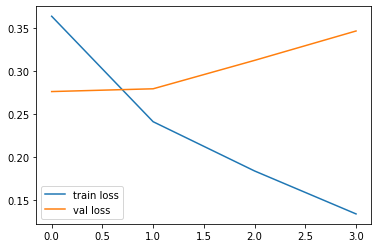

In [17]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.show()

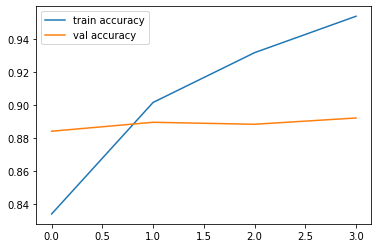

In [18]:
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='val accuracy')
plt.legend()
plt.show()

In [19]:
torch.cuda.empty_cache() 
gc.collect()

6680

In [20]:
#Testing


# pred=[]
# for epoch in range(epochs):
#     model.eval()
#     for xbatch in testloader:
#         yhat = model(xbatch)
#         pred.append(yhat)
        
# prediction = torch.row_stack(pred)
# test_review["sentiment"]=torch.argmax(pred, dim=1).cpu()
# test_review[["id","sentiment"]].to_csv('submission.csv', index=False, header=True)